# CNN Model:

In [1]:
# Downloading the dataset:

from google.colab import files

!pip install -q kaggle
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content --unzip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0


In [2]:
# Get the imports needed:

import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Data paths and basic settings:

my_base_dir = "/content/"
my_train_dir = os.path.join(my_base_dir, "Training")
my_test_dir = os.path.join(my_base_dir, "Testing")
my_cleaned_base_dir = os.path.join(my_base_dir, "cleaned")
my_cleaned_train_dir = os.path.join(my_cleaned_base_dir, "Training")
my_cleaned_test_dir = os.path.join(my_cleaned_base_dir, "Testing")

IMAGE_WIDTH_HEIGHT = 224
BATCH_SIZE = 32
MAX_EPOCHS = 100
NUM_CLASSES = 4
CLASS_NAMES_LIST = sorted(os.listdir(my_train_dir))

In [4]:
# Crop Images: (This function is provided by the dataset author!)
# https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
# ------------------------------------------
# Function to crop the brain part of the image to isolate the brain region:

def crop_brain_image(image_data):
    """ Crops the brain part from the image using contours. """
    gray_image = cv2.cvtColor(image_data, cv2.COLOR_RGB2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0)
    binary_image = cv2.threshold(blurred_image, 45, 255, cv2.THRESH_BINARY)[1]
    eroded_image = cv2.erode(binary_image, None, iterations=2)
    dilated_image = cv2.dilate(eroded_image, None, iterations=2)
    image_contours, _ = cv2.findContours(dilated_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not image_contours:
        return cv2.resize(image_data, (IMAGE_WIDTH_HEIGHT, IMAGE_WIDTH_HEIGHT))

    main_contour = max(image_contours, key=cv2.contourArea)
    left_point = tuple(main_contour[main_contour[:, :, 0].argmin()][0])
    right_point = tuple(main_contour[main_contour[:, :, 0].argmax()][0])
    top_point = tuple(main_contour[main_contour[:, :, 1].argmin()][0])
    bottom_point = tuple(main_contour[main_contour[:, :, 1].argmax()][0])
    PIXEL_PADDING = 0
    top = max(0, top_point[1]-PIXEL_PADDING)
    bottom = min(image_data.shape[0], bottom_point[1]+PIXEL_PADDING)
    left = max(0, left_point[0]-PIXEL_PADDING)
    right = min(image_data.shape[1], right_point[0]+PIXEL_PADDING)
    cropped_image = image_data[top:bottom, left:right].copy()

    if cropped_image.shape[0] > 0 and cropped_image.shape[1] > 0:
         resized_image = cv2.resize(cropped_image, (IMAGE_WIDTH_HEIGHT, IMAGE_WIDTH_HEIGHT))
    else:
         resized_image = cv2.resize(image_data, (IMAGE_WIDTH_HEIGHT, IMAGE_WIDTH_HEIGHT))
    return resized_image

# Apply cropping to all images:
def crop_and_save_dataset(original_data_dir, cleaned_data_dir):
    class_folders = os.listdir(original_data_dir)
    for class_name in class_folders:
        input_class_path = os.path.join(original_data_dir, class_name)
        output_class_path = os.path.join(cleaned_data_dir, class_name)
        os.makedirs(output_class_path, exist_ok=True)
        image_filenames = os.listdir(input_class_path)
        print(f"Cropping {class_name} images...")
        for img_name in image_filenames:
            img_path = os.path.join(input_class_path, img_name)
            image_bgr_loaded = cv2.imread(img_path)
            if image_bgr_loaded is not None:
                image_rgb_original = cv2.cvtColor(image_bgr_loaded, cv2.COLOR_BGR2RGB)
                cropped_rgb_image = crop_brain_image(image_rgb_original)
                cropped_bgr_to_save = cv2.cvtColor(cropped_rgb_image, cv2.COLOR_RGB2BGR)
                save_file_path = os.path.join(output_class_path, img_name)
                cv2.imwrite(save_file_path, cropped_bgr_to_save)


crop_and_save_dataset(my_train_dir, my_cleaned_train_dir)
crop_and_save_dataset(my_test_dir, my_cleaned_test_dir)
print("Image cropping is done")

Cropping notumor images...
Cropping glioma images...
Cropping meningioma images...
Cropping pituitary images...
Cropping notumor images...
Cropping glioma images...
Cropping meningioma images...
Cropping pituitary images...
Image cropping is done


In [5]:
# Load cropped images and set up basic augmentation without distorting the images:

image_augmentation_layer = keras.Sequential(
    [
        # Only using flip, rotation, zoom a little bit:
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.05),
        tf.keras.layers.RandomZoom(0.05)
    ],
    name="image_augmentation",
)

# Splitting the training dataset, 20% for validatio:

training_dataset = image_dataset_from_directory(
    my_cleaned_train_dir,
    label_mode='categorical',
    image_size=(IMAGE_WIDTH_HEIGHT, IMAGE_WIDTH_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training'
)


validation_dataset = image_dataset_from_directory(
    my_cleaned_train_dir,
    label_mode='categorical',
    image_size=(IMAGE_WIDTH_HEIGHT, IMAGE_WIDTH_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=123,
    validation_split=0.2,
    subset='validation'
)


testing_dataset = image_dataset_from_directory(
    my_cleaned_test_dir,
    label_mode='categorical',
    image_size=(IMAGE_WIDTH_HEIGHT, IMAGE_WIDTH_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False
)

rescale_pixels_layer = Rescaling(1./255)

# Mapping functions:
def augment_image(image, label):
    return image_augmentation_layer(image, training=True), label

def rescale_image(image, label):
    return rescale_pixels_layer(image), label

# Preparing datasets:
prefetch_buffer_size = tf.data.experimental.AUTOTUNE

# Process the training data - needs augmentation AND rescaling
training_dataset_processed = training_dataset.map(
    augment_image,
    num_parallel_calls=tf.data.AUTOTUNE # Keep this like it was
)
training_dataset_processed = training_dataset_processed.map(
    rescale_image,
    num_parallel_calls=tf.data.AUTOTUNE # And rescale
)
training_dataset_processed = training_dataset_processed.prefetch(
    buffer_size=prefetch_buffer_size # Make it faster
)

# Process the validation data - ONLY needs rescaling, NO augmentation!
# Use the 'validation_dataset' we created earlier
validation_dataset_processed = validation_dataset.map(
    rescale_image,                     # Just rescale
    num_parallel_calls=tf.data.AUTOTUNE
)
validation_dataset_processed = validation_dataset_processed.prefetch(
    buffer_size=prefetch_buffer_size # Make it faster too
)


# Process the test data - ONLY needs rescaling, like validation
testing_dataset_processed = testing_dataset.map(
    rescale_image,
    num_parallel_calls=tf.data.AUTOTUNE
)
testing_dataset_processed = testing_dataset_processed.prefetch(
    buffer_size=prefetch_buffer_size
)

print("Ok, Training, Validation, and Test datasets should be ready now.")

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Ok, Training, Validation, and Test datasets should be ready now.


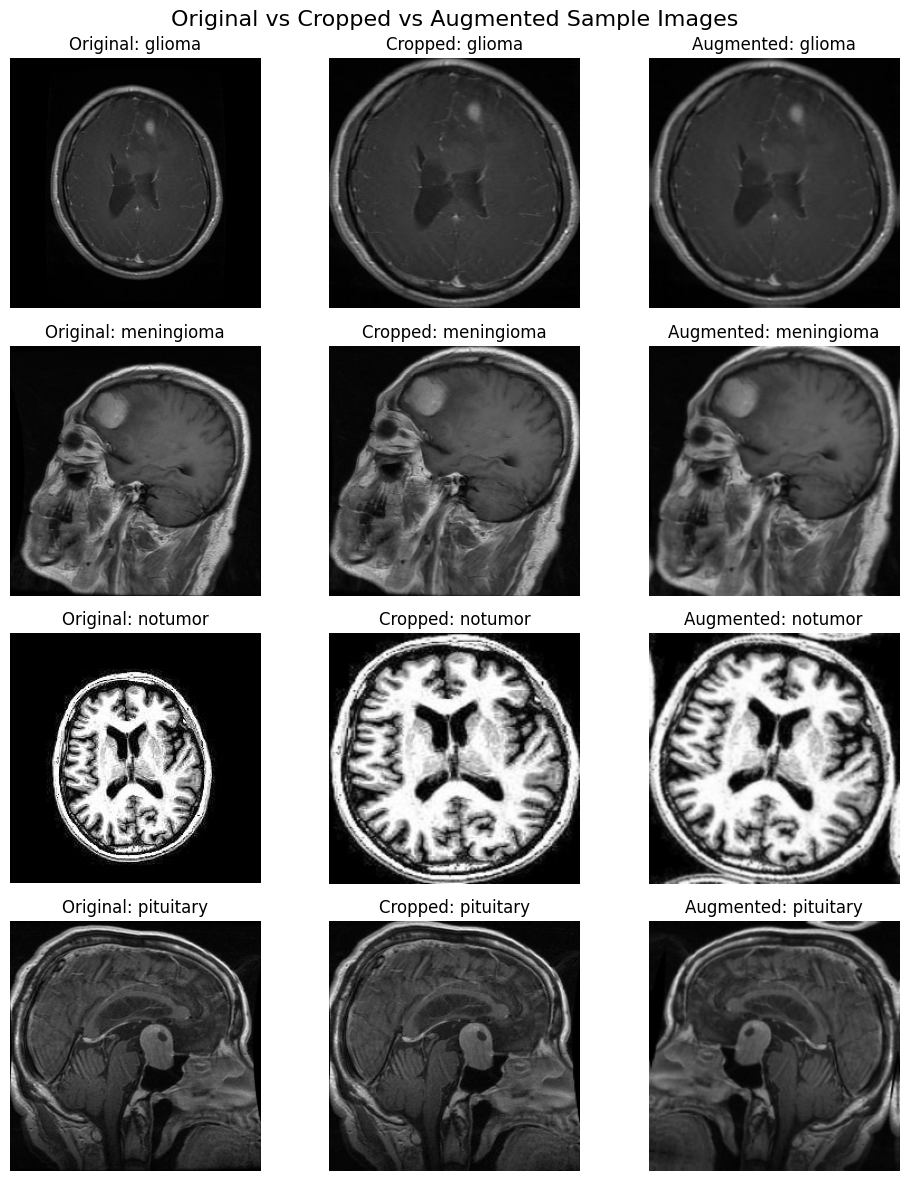

In [6]:
# Examples for original, cropped, and augmented version from every class:

plt.figure(figsize=(10, 12))


for i, class_name in enumerate(CLASS_NAMES_LIST):

    orig_path = os.path.join(my_train_dir, class_name)
    crop_path = os.path.join(my_cleaned_train_dir, class_name)

    # Get the first image:
    img_files = os.listdir(orig_path)
    first_img = img_files[0]

    # Load original image
    orig_img_path = os.path.join(orig_path, first_img)
    orig_img = cv2.imread(orig_img_path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    # Load cropped image
    crop_img_path = os.path.join(crop_path, first_img)
    crop_img = cv2.imread(crop_img_path)
    crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)

    # Make augmented image
    crop_tensor = tf.convert_to_tensor(crop_img, dtype=tf.float32)
    crop_batch = tf.expand_dims(crop_tensor, 0)
    aug_batch = image_augmentation_layer(crop_batch, training=True)
    aug_img = tf.squeeze(aug_batch, 0).numpy().astype(np.uint8)

    # Plot original image
    plt.subplot(4, 3, i*3 + 1)
    plt.imshow(orig_img)
    plt.title(f"Original: {class_name}")
    plt.axis("off")

    # Plot cropped image
    plt.subplot(4, 3, i*3 + 2)
    plt.imshow(crop_img)
    plt.title(f"Cropped: {class_name}")
    plt.axis("off")

    # Plot augmented image
    plt.subplot(4, 3, i*3 + 3)
    plt.imshow(aug_img)
    plt.title(f"Augmented: {class_name}")
    plt.axis("off")

plt.suptitle("Original vs Cropped vs Augmented Sample Images", fontsize=16)
plt.tight_layout()
plt.show()

Displaying class distribution...


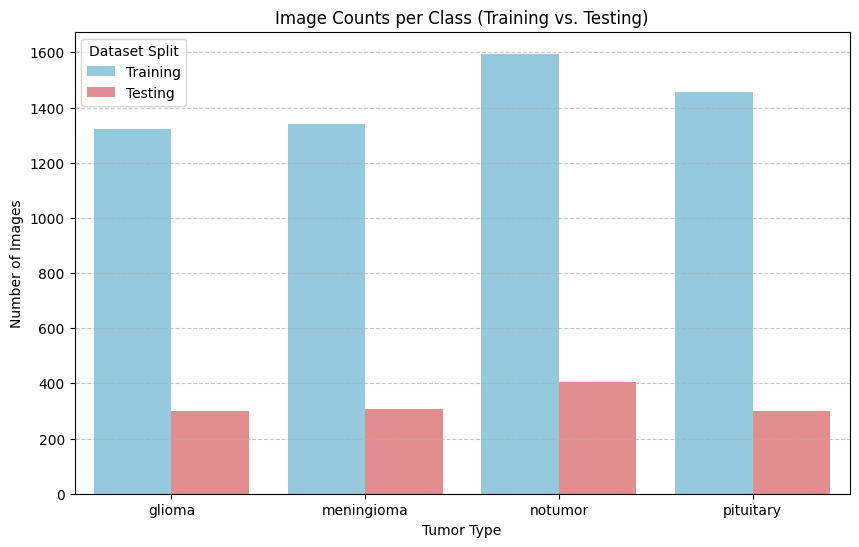

In [7]:
# A grouped bar chart for class distribution:

print("Displaying class distribution...")
train_image_counts = [len(os.listdir(os.path.join(my_cleaned_train_dir, name))) for name in CLASS_NAMES_LIST]
test_image_counts = [len(os.listdir(os.path.join(my_cleaned_test_dir, name))) for name in CLASS_NAMES_LIST]
image_counts_data = {
    'Class': CLASS_NAMES_LIST * 2,
    'Count': train_image_counts + test_image_counts,
    'Dataset Split': ['Training'] * NUM_CLASSES + ['Testing'] * NUM_CLASSES
}
df_counts = pd.DataFrame(image_counts_data)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_counts, x='Class', y='Count', hue='Dataset Split', palette=['skyblue', 'lightcoral'])
plt.title('Image Counts per Class (Training vs. Testing)')
plt.xlabel('Tumor Type')
plt.ylabel('Number of Images')
plt.legend(title='Dataset Split')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [8]:
# Building the CNN Model:
# Using a standard simple CNN structure:


input_layer_shape = (IMAGE_WIDTH_HEIGHT, IMAGE_WIDTH_HEIGHT, 3)
input_tensor = Input(shape=input_layer_shape)

# Convolutional Base:
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Classifier Head:
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.35)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax')(x)

# Create and compile model:
my_cnn_model = Model(inputs=input_tensor, outputs=output_layer, name="BrainTumor_CNN")
my_cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
my_cnn_model.summary()

Model: "BrainTumor_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,948 (49.36 MB)

 Trainable params: 12,938,948 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Model Training:

early_stopper_callback = EarlyStopping(
    monitor='val_loss', patience=10, verbose=1, restore_best_weights=True
)
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6
)

training_history = my_cnn_model.fit(
    training_dataset_processed,
    epochs=MAX_EPOCHS,
    validation_data=validation_dataset_processed,
    callbacks=[early_stopper_callback, reduce_lr_callback]
)
print("Training is done")

Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - accuracy: 0.4512 - loss: 1.3132 - val_accuracy: 0.8958 - val_loss: 0.4836 - learning_rate: 0.0010
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.7204 - loss: 0.6882 - val_accuracy: 0.7417 - val_loss: 0.7323 - learning_rate: 0.0010
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.7814 - loss: 0.5721 - val_accuracy: 0.8651 - val_loss: 0.4365 - learning_rate: 0.0010
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8079 - loss: 0.4959 - val_accuracy: 0.9291 - val_loss: 0.2113 - learning_rate: 0.0010
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8299 - loss: 0.4594 - val_accuracy: 0.9352 - val_loss: 0.1906 - learning_rate: 0.0010
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8421 - loss: 0.3901 - val_accuracy: 0.9623 - val_loss: 0.1340 - learning_rate: 0.0010
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8522 - 

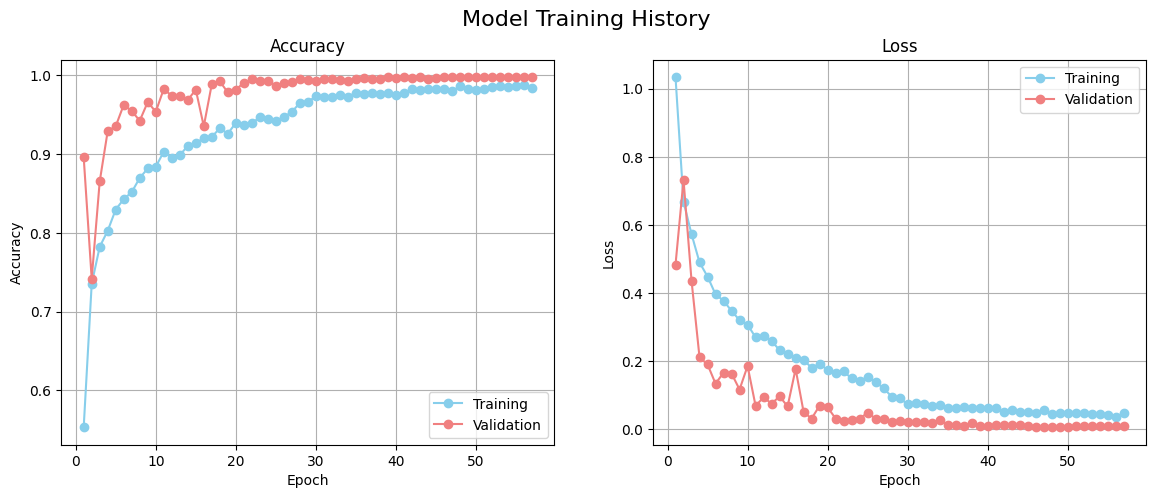

In [10]:
# Evaluating the Model:


# Performance Graphs:
accuracy_values = training_history.history['accuracy']
val_accuracy_values = training_history.history['val_accuracy']
loss_values = training_history.history['loss']
val_loss_values = training_history.history['val_loss']
epochs_completed = range(1, len(accuracy_values) + 1)

plt.figure(figsize=(14, 5))

# Accuracy Graph:
plt.subplot(1, 2, 1)
plt.plot(epochs_completed, accuracy_values, 'o-', color='skyblue', label='Training')
plt.plot(epochs_completed, val_accuracy_values, 'o-', color='lightcoral', label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Graph:
plt.subplot(1, 2, 2)
plt.plot(epochs_completed, loss_values, 'o-', color='skyblue', label='Training')
plt.plot(epochs_completed, val_loss_values, 'o-', color='lightcoral', label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training History', fontsize=16)
plt.show()

In [11]:
# Performance on the test dataset:

final_loss_value, final_accuracy_value = my_cnn_model.evaluate(testing_dataset_processed, verbose=0)

print(f"Test Loss: {final_loss_value:.4f}")
print(f"Test Accuracy: {final_accuracy_value:.4f} ({(final_accuracy_value*100):.2f}%)")

Test Loss: 0.2218
Test Accuracy: 0.9535 (95.35%)


In [12]:
# Classification Report:

test_predictions_probabilities = my_cnn_model.predict(testing_dataset_processed)
test_predictions_indices = np.argmax(test_predictions_probabilities, axis=1)

# Get true labels:
true_test_labels_list = []
for _, labels in testing_dataset:
    true_test_labels_list.append(np.argmax(labels.numpy(), axis=1))
true_test_labels_indices = np.concatenate(true_test_labels_list)

# Classification Report:

print("Classification Report: ")
report = classification_report(
    true_test_labels_indices,
    test_predictions_indices,
    target_names=CLASS_NAMES_LIST
)
print(report)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Classification Report: 
              precision    recall  f1-score   support

      glioma       0.99      0.89      0.94       300
  meningioma       0.91      0.93      0.92       306
     notumor       0.95      0.99      0.97       405
   pituitary       0.97      0.98      0.98       300

    accuracy                           0.95      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



Confusion Matrix: 


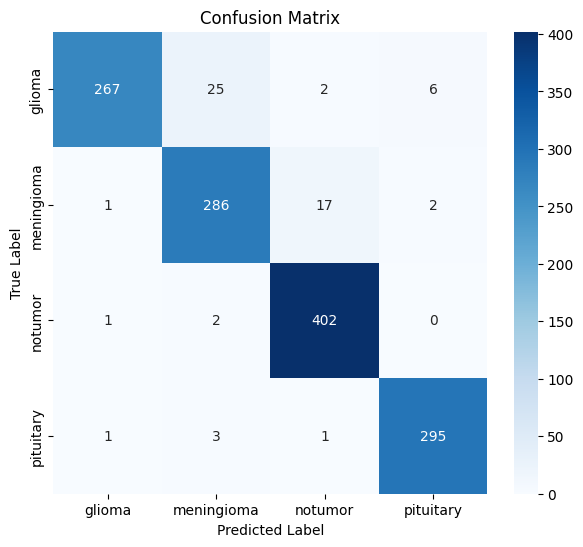

In [13]:
# Confusion Matrix:

print("Confusion Matrix: ")
confusion_mat = confusion_matrix(true_test_labels_indices, test_predictions_indices)
plt.figure(figsize=(7, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES_LIST, yticklabels=CLASS_NAMES_LIST)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Saving the model after training:

model_save_path = os.path.join(my_base_dir, "brain_tumor_CNN.keras")
my_cnn_model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/brain_tumor_CNN.keras


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_4']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


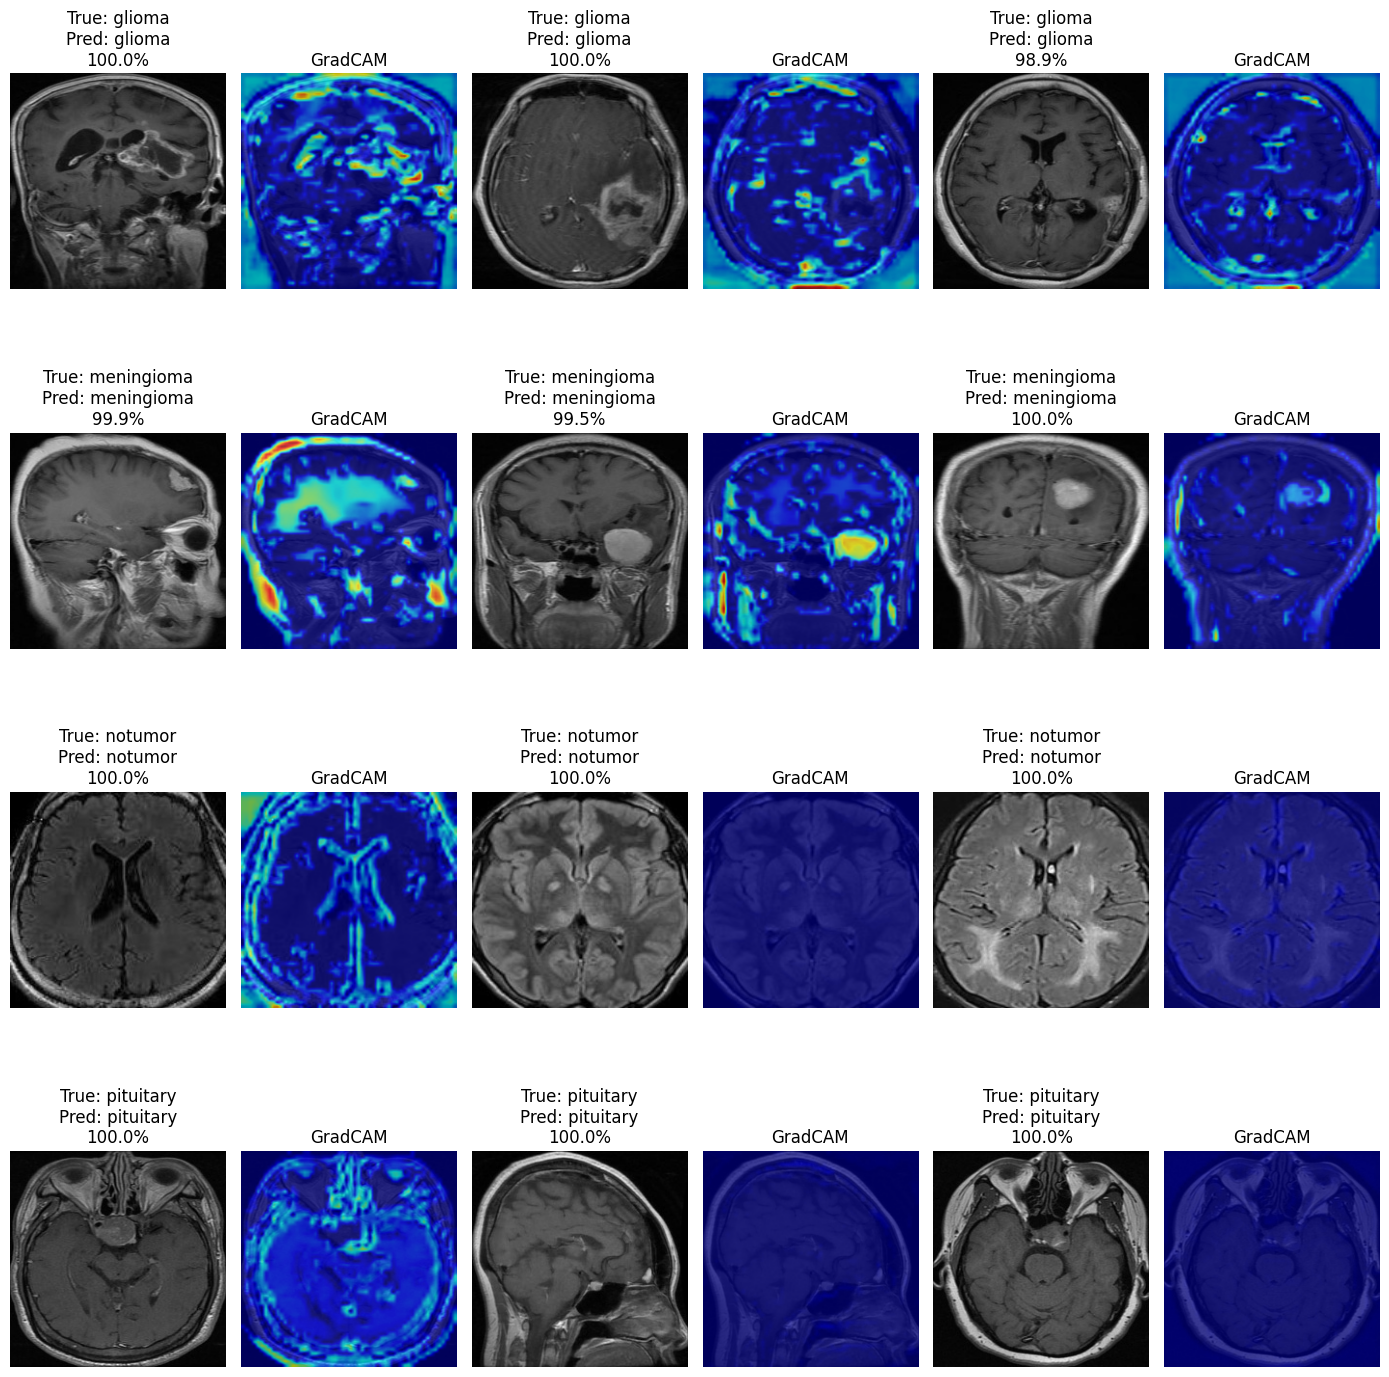

In [15]:
# Simple Grad-CAM visualization:

def gradcam(img, model, pred_idx):

    # Using the last layer:
    target_layer = "conv2d_2"

    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(target_layer).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img)
        loss = preds[:, pred_idx]

    grads = tape.gradient(loss, conv_out)
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))
    cam = tf.reduce_sum(tf.multiply(conv_out[0], weights), axis=-1)


    cam = tf.maximum(cam, 0) / (tf.reduce_max(cam) + 1e-7)
    return cam.numpy()



plt.figure(figsize=(14, 15))
for i, cls in enumerate(CLASS_NAMES_LIST):
    samples = random.sample(os.listdir(os.path.join(my_cleaned_test_dir, cls)), 3)

    for j, img_file in enumerate(samples):
        img = cv2.imread(os.path.join(my_cleaned_test_dir, cls, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMAGE_WIDTH_HEIGHT, IMAGE_WIDTH_HEIGHT))

        tensor = np.expand_dims(img/255.0, axis=0)
        pred = my_cnn_model.predict(tensor, verbose=0)
        pred_idx = np.argmax(pred[0])
        pred_cls = CLASS_NAMES_LIST[pred_idx]
        score = pred[0][pred_idx] * 100

        heatmap = gradcam(tensor, my_cnn_model, pred_idx)


        heatmap = np.power(heatmap, 0.5)

        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        colored = cv2.cvtColor(colored, cv2.COLOR_BGR2RGB)

        # Increase heatmap visibility:
        overlay = (colored * 0.7 + img * 0.3).astype(np.uint8)

        plt.subplot(4, 6, i*6 + j*2 + 1)
        plt.imshow(img)
        plt.title(f"True: {cls}\nPred: {pred_cls}\n{score:.1f}%")
        plt.axis('off')

        plt.subplot(4, 6, i*6 + j*2 + 2)
        plt.imshow(overlay)
        plt.title("GradCAM")
        plt.axis('off')

plt.tight_layout()
plt.show()